# XCLASS: creating images for targets

For Matej Kosiba's neural network training. Workflow to download and save images. There will be 3 images per target coordinates: one optical from DSS22 red band, and two XMM-Newton for two bands.

1. Set the coordinates of the target.
1. Identify the observation id (`OBS_ID`) where the target falls in, using `astroquery.esasky` module.
1. Get XMM-Newton pipeline (PPS) images for the PN in all 4 bands that contain the target. Using NXSA URL access.
1. Combine bands 2+3 and 4+5 to make two X-ray images in the soft band [0.5-2.0] keV and hard band [2.0-12.0] keV.
1. Get the DSS2 Red band image withint the input box size from SkyView using `astroquery.skyview` module.
1. Save the optical image.
1. Crop the X-ray images in the user selected box (usually the same as the optical).
1. Save th ecropped X-ray images
1. In parallel, display the three images in the notebook.

**Note:** the optical and the X-ray cropped images will be saved without any re-normalisation.


In [177]:
import os
import tarfile
import requests
import shutil

import numpy as np

from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

from astropy.coordinates import SkyCoord
from astropy import units as u

from astroquery.esasky import ESASky

%matplotlib inline
import matplotlib.pylab as plt

home = os.path.expanduser('~')
tmpdir = os.path.join(home,"tmp","XMM_data")
if (not os.path.isdir(tmpdir)):
    print ("Please set the tmpdir to an aleady existing folder. It is needed.")
    raise FileNotFoundError
#

## Identify XMM OBS_ID for the point of interest

Will use `astroquery.esasky` to identify the `OBS_ID` where the target coordinates are.

In [179]:
ra = "10h01m17.49s"
dec= "+28d51m11.4s"
c = SkyCoord(ra, dec, frame='icrs')
# box size for the region of interest, the images will be cropped to it.
box = 6.0*u.arcmin

In [180]:
result = ESASky.get_images(c, radius='2 arcmin', missions=['XMM'],download_dir=tmpdir)

INFO: Starting download of XMM data. (1 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 0405340101 from http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=PRODUCT&OBS_IMAGE_TYPE=OBS_EPIC&PROTOCOL=HTTP&OBSERVATION_ID=0405340101 [astroquery.esasky.core]


INFO: [Done] [astroquery.esasky.core]
INFO: Downloading of XMM data complete. [astroquery.esasky.core]
INFO: Maps available at /home/ivaltchanov/tmp/XMM_data [astroquery.esasky.core]


In [181]:
# pick up the first one
#
# TODO: if more than one match what to do? Pick up the one with higher exposure time? or the one where the target is near the centre?
#
obsid = result['XMM'][0][0].header["OBS_ID"]

## Download the tar file from the XMM archive

Once we have the `OBS_ID` then we proceed using [the URL access](http://nxsa.esac.esa.int/nxsa-web/#aio_client) to the XMM-Newton archive.

In [182]:
#ftype = 'SRSPEC0001'
ftype = "IMAGE"
extn = "FTZ"
inst = "PN"
url = 'http://nxsa.esac.esa.int/nxsa-sl/servlet'
#req  = f"{url}/data-action-aio?obsno={iobs}&name={ftype}&level=PPS"
req  = f"{url}/data-action-aio?obsno={obsid}&extension={extn}&name={ftype}&instname={inst}&level=PPS"

tarFile = f"{tmpdir}/pps_{obsid}.tar"

with requests.get(req) as r:
    #r.raise_for_status() # ensure we notice bad responses
    if (b'No results' in r.content):
        print ("No PPS products found for {obsid}")
        raise Exception
    else:
        with open(tarFile,"wb") as tmp:
            tmp.write(r.content)
print (f"{inst} images in all bands saved to {tarFile}")

PN images in all bands saved to /home/ivaltchanov/tmp/XMM_data/pps_0405340101.tar


## Extract the images

Here we extract the images and then co-add the bands to create two images in bands [0.5-2] and [2-12.0] keV. This means co-adding band 2+3 and 4+5.

In [184]:
bands = [2,3,4,5]
maps = {}
with tarfile.open(tarFile,'r') as tar:
    for xband in bands:
        sband = f'{xband}000'
        for member in tar.getmembers():
            if (sband in member.name):
                print (f"Extracting {member.name}")
                f=tar.extract(member,path=tmpdir)
                hdu = fits.open(f"{tmpdir}/{member.name}")
                maps[sband] = hdu[0]
#
# co-adding 
#
sb = maps['2000'].data + maps['3000'].data
hb = maps['4000'].data + maps['5000'].data
hdu_soft = fits.PrimaryHDU(sb)
hdu_soft.header = maps['2000'].header
hdu_hard = fits.PrimaryHDU(hb)
hdu_hard.header = maps['4000'].header

Extracting 0405340101/pps/P0405340101PNS003IMAGE_2000.FTZ
Extracting 0405340101/pps/P0405340101PNS003IMAGE_3000.FTZ
Extracting 0405340101/pps/P0405340101PNS003IMAGE_4000.FTZ
Extracting 0405340101/pps/P0405340101PNS003IMAGE_5000.FTZ


In [185]:
from astroquery.skyview import SkyView

paths = SkyView.get_images(c,survey=['DSS2 Red'],width=box,height=box, coordinates="ICRS")

In [186]:
saveToFits = True
output_dir = tmpdir = os.path.join(home,"tmp","XMM_data","outputs")
if ((not os.path.isdir(output_dir)) and saveToFits):
    print ("Please set the output_dir to an aleady existing folder. It is needed.")
    raise FileNotFoundError

In [187]:
paths[0][0].writeto(f"{output_dir}/{obsid}_dss2r_norm.fits",overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


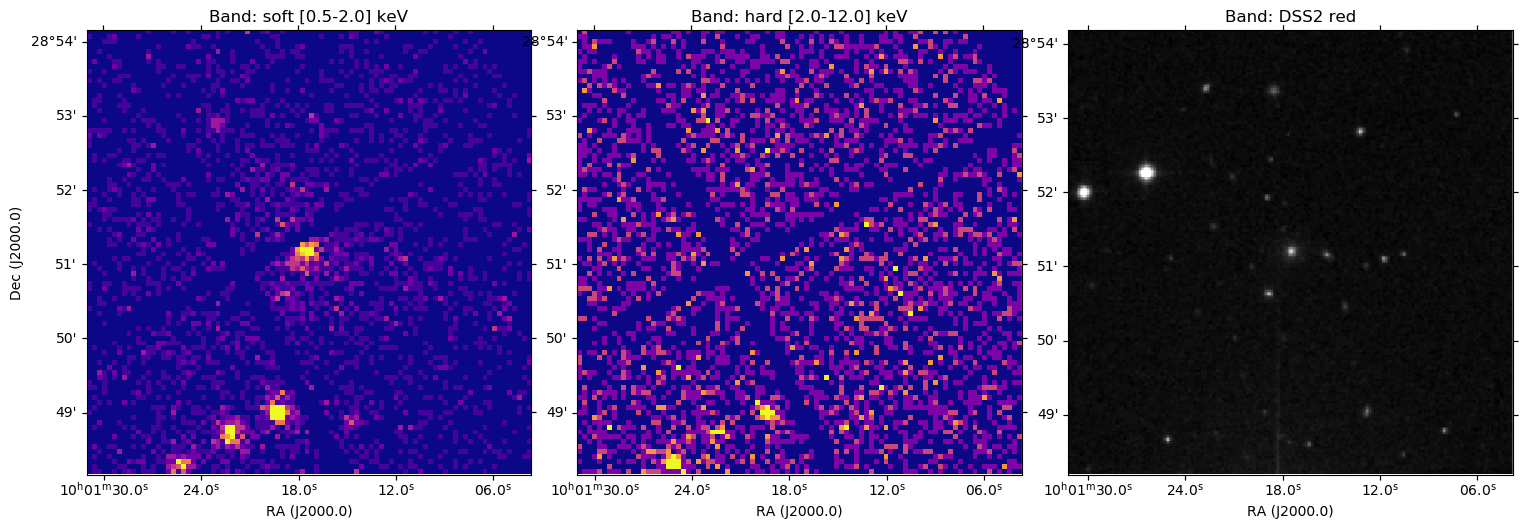

In [188]:
#
# plotting
#
zoomSize = u.Quantity((box,box), u.arcmin)
#
fig = plt.figure(figsize=(15,5),dpi=100)
#
pp = 99.5 #
# labels for the plots
bands = ["soft [0.5-2.0]","hard [2.0-12.0]"]
qbands = ["500_2000","2000_12000"]
#
for i,ximage in enumerate([hdu_soft,hdu_hard]):
    wcs = WCS(ximage.header)
    cutout = Cutout2D(ximage.data, c, zoomSize, wcs=wcs)
    wcs_cut = cutout.wcs
    ax = fig.add_subplot(1,3,i+1,projection=wcs_cut)
    ax.set_title(f'Band: {bands[i]} keV')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    lat.set_major_formatter('dd:mm')
    if (i == 0):
        lat.set_axislabel('Dec (J2000.0)')
    # now normalize the imahe
    norm = ImageNormalize(cutout.data[~np.isnan(cutout.data)], interval=PercentileInterval(pp))
    ax.imshow(cutout.data,norm=norm,cmap=plt.cm.plasma,origin='lower',interpolation='nearest')
    ax.set_autoscale_on(False)
    if (saveToFits):
        xdu = fits.PrimaryHDU(cutout.data)
        xdu.header = ximage.header
        xdu.header.update(cutout.wcs.to_header())
        xdu.writeto(f"{output_dir}/{obsid}_{qbands[i]}_norm.fits",overwrite=True)
    #    
#
# now the DSS2 Red image
pp = 99.9 #
rimage = paths[0][0]
#rimage.data[~np.isnan(rimage.data)]
wcs = WCS(rimage.header)
ax = fig.add_subplot(1,3,3,projection=wcs)
ax.set_title('Band: DSS2 red')
lon = ax.coords['ra']
lon.set_axislabel('RA (J2000.0)')
lon.set_major_formatter('hh:mm:ss.s')
lat = ax.coords['dec']
#lat.set_axislabel('Dec (J2000.0)')
lat.set_major_formatter('dd:mm')
# now normalize the imahe
norm = ImageNormalize(rimage.data[~np.isnan(rimage.data)], interval=PercentileInterval(pp))
ax.imshow(rimage.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
ax.set_autoscale_on(False)
#
plt.tight_layout(pad=2)
#lgnd = plt.legend(bbox_to_anchor=(0.2, -0.05))
#lgnd.legendHandles[0]._sizes = [50];

In [189]:
print (f"Images for {obsid} saved to folder {output_dir}")

Images for 0405340101 saved to folder /home/ivaltchanov/tmp/XMM_data/outputs
